# Description

In this project, we will train two models, UNet and FCN8s, to perform semantic segmentation. The dataset used is sourced from Indonesia AI, derived from the Cityscapes dataset. It consists of images capturing a car's surroundings along with corresponding semantic segmentation labels. The objective of this study is to compare the performance of both models and determine which one is more effective for this specific case.

# Import Lib

In [1]:
import gdown
import zipfile
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn as nn
from torchvision import transforms
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
from tqdm import tqdm
import torchvision.models as models

import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
import torch.nn.functional as F

import torchvision
from torchvision.models.detection import MaskRCNN
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

We delete the data folder to prevent duplication in case we need to restart and rerun the notebook

In [2]:
!rm -rf data

# Data Collection

In [3]:
!mkdir data/
!mkdir data/saved_model/

url1 = "https://drive.google.com/uc?id=1GwExwixckvu5sEZTMUkcyEtsRD9Dk8N3"
url2 = "https://drive.google.com/uc?id=14vlTnRa3no-ZNxA_tSNsePLjdDZ3JEQ9"
url3 = "https://drive.google.com/uc?id=1QwbNCh9NXMkyEX8PtJCGUJuXWbgqXqnh"
url4 = "https://drive.google.com/uc?id=1tnJdNTvMFBOJp7OxW2vuM0SPPhlp2B4S"

gdown.download(url1)
gdown.download(url2)
gdown.download(url3)
gdown.download(url4)

Downloading...
From: https://drive.google.com/uc?id=1GwExwixckvu5sEZTMUkcyEtsRD9Dk8N3
To: /content/annotations_prepped_train-20241111T025913Z-001.zip
100%|██████████| 2.30M/2.30M [00:00<00:00, 124MB/s]
Downloading...
From: https://drive.google.com/uc?id=14vlTnRa3no-ZNxA_tSNsePLjdDZ3JEQ9
To: /content/annotations_prepped_test-20241111T025903Z-001.zip
100%|██████████| 566k/566k [00:00<00:00, 75.3MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1QwbNCh9NXMkyEX8PtJCGUJuXWbgqXqnh
From (redirected): https://drive.google.com/uc?id=1QwbNCh9NXMkyEX8PtJCGUJuXWbgqXqnh&confirm=t&uuid=ab302baa-1388-4c47-bd64-764a6b7d7d57
To: /content/images_prepped_test-20241111T025016Z-001.zip
100%|██████████| 28.6M/28.6M [00:00<00:00, 72.6MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1tnJdNTvMFBOJp7OxW2vuM0SPPhlp2B4S
From (redirected): https://drive.google.com/uc?id=1tnJdNTvMFBOJp7OxW2vuM0SPPhlp2B4S&confirm=t&uuid=d993c1ee-a081-4d34-8970-3d61aed67d94
To: /content/images_p

'images_prepped_train-20241111T024959Z-001.zip'

In [4]:
!mv annotations_prepped_train-20241111T025913Z-001.zip /content/data
!mv annotations_prepped_test-20241111T025903Z-001.zip /content/data
!mv images_prepped_test-20241111T025016Z-001.zip /content/data
!mv images_prepped_train-20241111T024959Z-001.zip /content/data

In [5]:
!unzip data/annotations_prepped_train-20241111T025913Z-001.zip -d /content/data
!unzip data/annotations_prepped_test-20241111T025903Z-001.zip -d /content/data
!unzip data/images_prepped_test-20241111T025016Z-001.zip -d /content/data
!unzip data/images_prepped_train-20241111T024959Z-001.zip -d /content/data

Archive:  data/annotations_prepped_train-20241111T025913Z-001.zip
  inflating: /content/data/annotations_prepped_train/0006R0_f03210.png  
  inflating: /content/data/annotations_prepped_train/0001TP_007230.png  
  inflating: /content/data/annotations_prepped_train/0016E5_07320.png  
  inflating: /content/data/annotations_prepped_train/0016E5_07290.png  
  inflating: /content/data/annotations_prepped_train/0016E5_02220.png  
  inflating: /content/data/annotations_prepped_train/0006R0_f02550.png  
  inflating: /content/data/annotations_prepped_train/0016E5_06930.png  
  inflating: /content/data/annotations_prepped_train/0016E5_07680.png  
  inflating: /content/data/annotations_prepped_train/0006R0_f01140.png  
  inflating: /content/data/annotations_prepped_train/0016E5_01440.png  
  inflating: /content/data/annotations_prepped_train/0016E5_05820.png  
  inflating: /content/data/annotations_prepped_train/0016E5_08430.png  
  inflating: /content/data/annotations_prepped_train/0001TP_007080

# Data Cleansing

In [6]:
PATH = "/content/data/images_prepped_train"
files_list = os.listdir(PATH)
print(files_list)

['0016E5_02400.png', '0001TP_007410.png', '0016E5_04830.png', '0016E5_01860.png', '0006R0_f03720.png', '0016E5_01260.png', '0016E5_01590.png', '0006R0_f01860.png', '0001TP_007290.png', '0016E5_00690.png', '0006R0_f01230.png', '0006R0_f01800.png', '0016E5_07080.png', '0006R0_f03840(1).png', '0006R0_f03210.png', '0006R0_f02490.png', '0016E5_06210.png', '0016E5_07590.png', '0016E5_00720.png', '0001TP_007860.png', '0006R0_f03060.png', '0016E5_02010.png', '0016E5_07710.png', '0006R0_f03090.png', '0001TP_007950.png', '0006R0_f02790.png', '0006R0_f02760.png', '0006R0_f03840.png', '0016E5_05100.png', '0006R0_f03570.png', '0016E5_05160.png', '0016E5_01710.png', '0006R0_f01470.png', '0001TP_006960.png', '0016E5_07860(1).png', '0006R0_f02700.png', '0006R0_f01680.png', '0016E5_05070.png', '0006R0_f01770.png', '0016E5_06630.png', '0016E5_06840.png', '0016E5_06060.png', '0016E5_05010.png', '0016E5_05850.png', '0016E5_05970.png', '0006R0_f03030.png', '0016E5_06150.png', '0016E5_06540.png', '0016E5_06

We noticed that some files are duplicated, identifiable by "(1)" or "(2)" in their filenames. Therefore, we will remove these duplicate files

In [7]:
PATH = "/content/data/images_prepped_train"
files_list = os.listdir(PATH)

for file_name in files_list:
    if "(" in file_name and ")" in file_name:
        file_path = os.path.join(PATH, file_name)
        os.remove(file_path)
        print(f'Deleted: {file_name}')

Deleted: 0006R0_f03840(1).png
Deleted: 0016E5_07860(1).png
Deleted: 0016E5_07710(2).png
Deleted: 0016E5_07650(1).png
Deleted: 0016E5_07800(1).png
Deleted: 0016E5_07740(1).png
Deleted: 0016E5_07770(1).png
Deleted: 0016E5_07830(2).png
Deleted: 0016E5_07920(1).png
Deleted: 0016E5_07920(2).png
Deleted: 0016E5_07650(2).png
Deleted: 0006R0_f03750(1).png
Deleted: 0006R0_f03660(1).png
Deleted: 0006R0_f03930(1).png
Deleted: 0016E5_07620(2).png
Deleted: 0006R0_f03810(1).png
Deleted: 0016E5_05400(1).png
Deleted: 0016E5_07680(1).png
Deleted: 0016E5_07680(2).png
Deleted: 0016E5_07710(1).png
Deleted: 0006R0_f03720(1).png
Deleted: 0016E5_07770(2).png
Deleted: 0016E5_07740(2).png
Deleted: 0006R0_f03630(1).png
Deleted: 0016E5_07860(2).png
Deleted: 0006R0_f03780(1).png
Deleted: 0006R0_f03690(1).png
Deleted: 0016E5_07620(1).png
Deleted: 0016E5_07800(2).png
Deleted: 0006R0_f03600(1).png
Deleted: 0016E5_07830(1).png


In [8]:
PATH = "/content/data/images_prepped_test"
files_list = os.listdir(PATH)

for file_name in files_list:
    if "(" in file_name and ")" in file_name:
        file_path = os.path.join(PATH, file_name)
        os.remove(file_path)
        print(f'Deleted: {file_name}')

In [9]:
PATH = "/content/data/annotations_prepped_train"
files_list = os.listdir(PATH)

for file_name in files_list:
    if "(" in file_name and ")" in file_name:
        file_path = os.path.join(PATH, file_name)
        os.remove(file_path)
        print(f'Deleted: {file_name}')

In [10]:
PATH = "/content/data/annotations_prepped_test"
files_list = os.listdir(PATH)

for file_name in files_list:
    if "(" in file_name and ")" in file_name:
        file_path = os.path.join(PATH, file_name)
        os.remove(file_path)
        print(f'Deleted: {file_name}')

# EDA

In [11]:
PATH = "/content/data/images_prepped_train"
files_list = os.listdir(PATH)
print(f'The number of train dataset is {len(files_list)}')

PATH = "/content/data/images_prepped_test"
files_list = os.listdir(PATH)
print(f'The number of test dataset is {len(files_list)}')

The number of train dataset is 367
The number of test dataset is 101


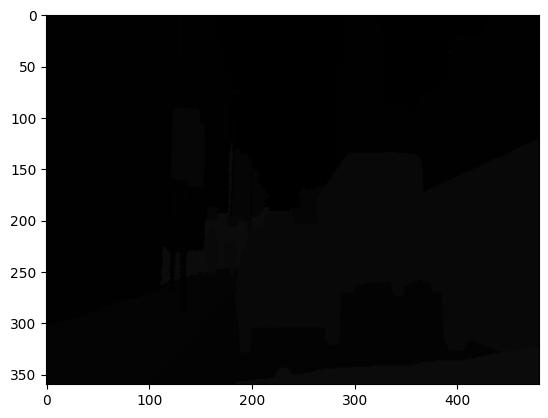

In [12]:
mask = cv2.imread("/content/data/annotations_prepped_train/0001TP_006690.png")
plt.imshow(mask)
plt.show()

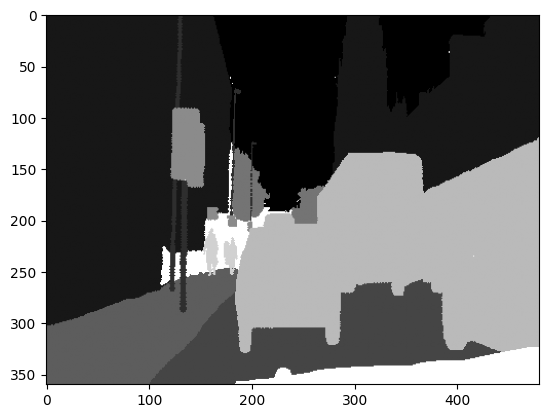

In [13]:
#visualize the image using grayscale

mask = cv2.imread("/content/data/annotations_prepped_train/0001TP_006690.png", cv2.IMREAD_GRAYSCALE)
plt.imshow(mask, cmap='gray')
plt.show()

# Data Preprocessing

In [14]:
#apply image transformation

data_transforms = A.Compose([
    A.Resize(256,256),
    A.Normalize(),
    ToTensorV2()
])

In [15]:
#explore the result of transformations

PATH = "/content/data/images_prepped_train"
files_list = os.listdir(PATH)
file_name = os.path.join(PATH, files_list[0])

image = Image.open(file_name).convert('RGB')
image_ori = np.array(image)

mask_ori = os.path.join("/content/data/annotations_prepped_train", files_list[0])

mask = Image.open(mask_ori).convert('L')
mask = np.asarray(mask)

unique_classes = np.unique(mask)

output = data_transforms(image=image_ori, mask=mask)
image = output['image']
mask = output['mask']

image = image.cpu().numpy()
image = np.transpose(image, (1, 2, 0))
image = (image + 1) * 127.5
image = np.clip(image, 0, 255).astype('uint8')

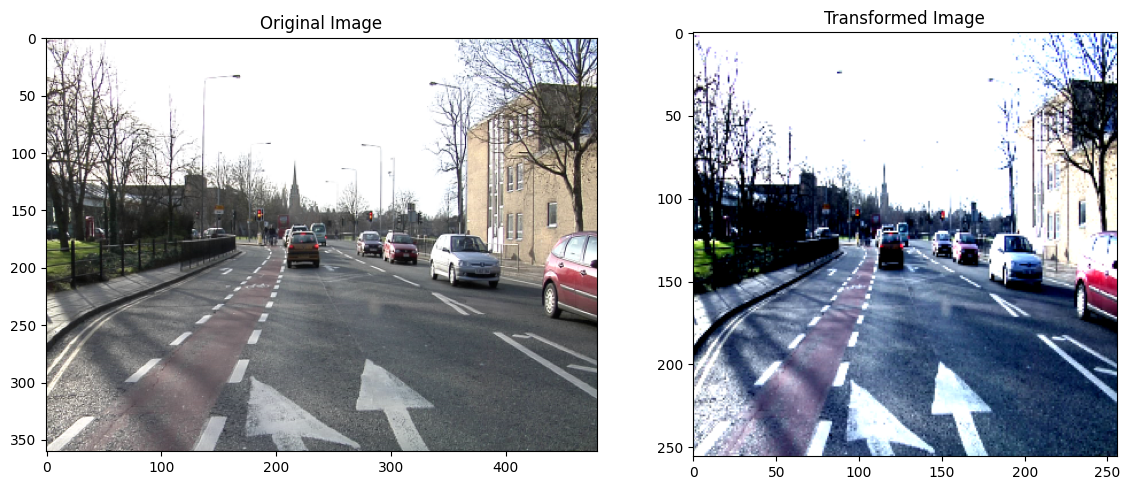

In [16]:
#visualize the samples

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_ori)
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(image)
plt.title('Transformed Image')

plt.tight_layout()
plt.show()

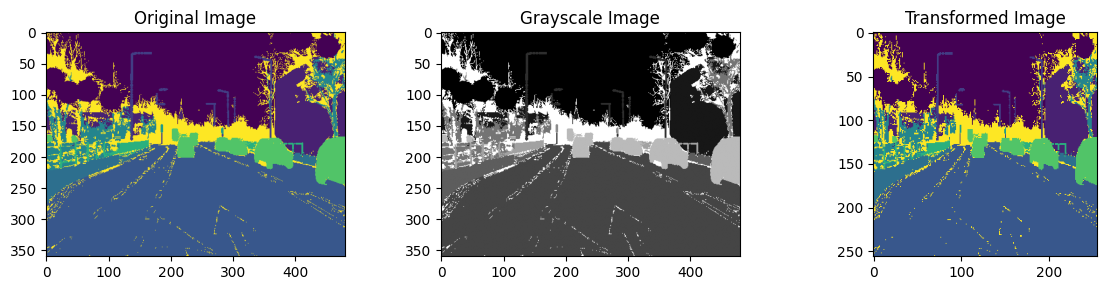

In [17]:
#visualize the annotation image

mask_ori = cv2.imread(mask_ori, cv2.IMREAD_GRAYSCALE)

plt.figure(figsize=(12, 3))

plt.subplot(1, 3, 1)
plt.imshow(mask_ori)
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(mask_ori, cmap='gray')
plt.title('Grayscale Image')

plt.subplot(1, 3, 3)
plt.imshow(mask)
plt.title('Transformed Image')

plt.tight_layout()
plt.show()

# Dataset Class

In [18]:
#check number of class

max_class_fix = 0
PATH = "/content/data/annotations_prepped_train"
files_list = os.listdir(PATH)

for i in range(len(files_list)):
  mask_ori = os.path.join(PATH, files_list[i])
  mask = Image.open(mask_ori)
  mask = np.array(mask)
  unique_classes = np.unique(mask)
  max_class = np.max(unique_classes)
  if max_class > max_class_fix:
    max_class_fix = max_class

print(f'The number of classes is: {max_class_fix+1}')

The number of classes is: 12


In [19]:
#encode all the classes

class Cityscapes(Dataset):
    def __init__(self, files_list, img_path, ann_path, num_classes=12):
        super().__init__()
        self.files_list = files_list
        self.img_path = img_path
        self.ann_path = ann_path
        self.num_classes = num_classes

    def __len__(self):
        return len(self.files_list)

    def __getitem__(self, idx):
        file_img = os.path.join(self.img_path, self.files_list[idx])
        mask_file = os.path.join(self.ann_path, self.files_list[idx])

        # Load the image and convert to RGB
        image = Image.open(file_img).convert('RGB')
        image = np.asarray(image)

        # Load the mask and convert to a numpy array
        mask = Image.open(mask_file).convert('L')
        mask = np.asarray(mask)

        # Apply the transformation
        output = data_transforms(image=image, mask=mask)
        image = output['image']
        mask = output['mask']

        # One-hot encode the mask
        mask = to_categorical(mask, num_classes=self.num_classes)

        # Change shape to [num_classes, height, width]
        mask = mask.transpose(2, 0, 1)

        return image, torch.tensor(mask, dtype=torch.float32)

# Data Splitting (80Tr:20Vl)

In [20]:
PATH = "/content/data/images_prepped_train"
files = os.listdir(PATH)
split = 0.8

for i in range(10):
  np.random.shuffle(files)

train_files = files[:int(len(files)*split)]
val_files = files[int(len(files)*split):]

In [21]:
img_path = "/content/data/images_prepped_train"
ann_path = "/content/data/annotations_prepped_train"

train_datasets = Cityscapes(train_files, img_path, ann_path)
val_datasets = Cityscapes(val_files, img_path, ann_path)

In [22]:
#create dataloader

train_dataloader = DataLoader(train_datasets, batch_size=32, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_datasets, batch_size=32, shuffle=True, num_workers=2)

In [23]:
#create test dataset n test dataloader

img_path = "/content/data/images_prepped_test"
ann_path = "/content/data/annotations_prepped_test"

test_files = os.listdir(img_path)
test_datasets = Cityscapes(test_files, img_path, ann_path)
test_dataloader = DataLoader(test_datasets, batch_size=32, shuffle=False, num_workers=2)

# Build Model

U-Net

In [24]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        # dobleconv, dobleconv..
        # Down part of UNET
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #upsam, doubleconv, up, ..
        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(#0
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(DoubleConv(feature*2, feature))#1

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1] # reversed(skip_connections)

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

In [25]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

unet = UNET(in_channels=3, out_channels=12)
unet.to(device)
optim_unet = torch.optim.Adam(unet.parameters(), lr = 1e-4)

**FCN8s**

In [26]:
class FCN8s(nn.Module):
    def __init__(self, num_classes):
        super(FCN8s, self).__init__()
        vgg16 = models.vgg16(weights=models.VGG16_Weights.DEFAULT)
        self.features = vgg16.features

        self.conv6 = nn.Conv2d(512, 4096, kernel_size=7)
        self.conv7 = nn.Conv2d(4096, 4096, kernel_size=1)
        self.score_fr = nn.Conv2d(4096, num_classes, kernel_size=1)

        self.score_pool4 = nn.Conv2d(512, num_classes, kernel_size=1)
        self.score_pool3 = nn.Conv2d(256, num_classes, kernel_size=1)

        self.upscore2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upscore_pool4 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1)
        self.upscore8 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4)

    def forward(self, x):
        pool3, pool4 = None, None

        # Extract features from VGG16
        for i, layer in enumerate(self.features):
            x = layer(x)
            if i == 16:  # After pool3
                pool3 = x
            elif i == 23:  # After pool4
                pool4 = x

        x = F.relu(self.conv6(x))
        x = F.dropout(x, p=0.5)
        x = F.relu(self.conv7(x))
        x = F.dropout(x, p=0.5)

        x = self.score_fr(x)
        x = self.upscore2(x)

        # Align dimensions and add skip connections
        score_pool4 = self.score_pool4(pool4)
        score_pool4 = F.interpolate(score_pool4, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = x + score_pool4
        x = self.upscore_pool4(x)

        score_pool3 = self.score_pool3(pool3)
        score_pool3 = F.interpolate(score_pool3, size=x.shape[2:], mode="bilinear", align_corners=False)
        x = x + score_pool3

        # Upsample to match the original image size
        x = self.upscore8(x)

        # Adjust to match y_true size which is 256 x 256
        x = F.interpolate(x, size=(256, 256), mode="bilinear", align_corners=False)
        return x

In [27]:
#set number of class n apply optimizer

fcn = FCN8s(num_classes=12)
fcn.to(device)
optim_fcn = torch.optim.Adam(fcn.parameters(), lr = 1e-4)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 170MB/s]


# Train Models

We define the train_engine function to train the model for each epoch and compute the corresponding loss. Within this function, we also use GradScaler to speed up the training process. Additionally, we implement the val_engine function to calculate the model's loss on the validation dataset

In [28]:
scaler = torch.amp.GradScaler(device='cuda')

def train_engine(dataloader, model, loss_fn, optim, scaler=scaler):
    model.train()
    loss_one_step = 0
    loop = tqdm(dataloader)
    for data, targets in loop:
        data = data.to('cuda')
        targets = targets.float().to(device="cuda")
        # forward
        with torch.amp.autocast('cuda'):
            predictions = model(data)
            loss = loss_fn(targets, predictions)

        optim.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optim)
        scaler.update()
        loss_one_step += loss.item()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

    return loss_one_step / len(dataloader)

def val_engine(dataloader, model, loss_fn):
    model.eval()
    loss_one_step = 0
    loop = tqdm(dataloader)

    for data, targets in loop:
        data = data.to('cuda')
        targets = targets.float().to(device="cuda")
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                predictions = model(data)
                loss = loss_fn(targets, predictions)
        loss_one_step += loss.item()

        loop.set_postfix(loss=loss.item())

    return loss_one_step / len(dataloader)

The two functions mentioned above are integrated into the train function, which manages the entire training process. This function also records the training and validation losses for later analysis. It returns the best-performing model based on the lowest validation loss observed during training and saves both the best and final models if the save_model parameter is set to True

In [29]:
def train(train_dataloaders, val_dataloaders, model, loss_fn, optim, num_epochs, log_freq=10, save_model=False, best_model_name='best_model.pth', last_model_name='last_model.pth'):
    """
    Train the model for a given number of epochs.
    :param train_dataloaders: A dictionary of dataloaders for training and validation.
    :param val_dataloaders: A dictionary of dataloaders for validation.
    :param model: The model to train.
    :param loss_fn: The loss function to use.
    :param optim: The optimizer to use.
    :param num_epochs: The number of epochs to train for.
    :param log_freq: The frequency with which to log training metrics.
    :return: The trained model.
    """
    best_model = None
    best_val_loss = float('inf')

    best_model_name = os.path.join('/content/data/saved_model/', best_model_name)
    last_model_name = os.path.join('/content/data/saved_model/', last_model_name)

    train_losses = []
    val_losses = []

    for epoch in range(num_epochs):
        train_loss = train_engine(train_dataloaders, model, loss_fn, optim)
        train_losses.append(train_loss)

        val_loss = val_engine(val_dataloaders, model, loss_fn)
        val_losses.append(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            if save_model:
                best_model = model
                torch.save(best_model.state_dict(), best_model_name)

        if epoch % log_freq == 0:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)
            print('Train Loss: {:.4f}'.format(train_loss))
            print('Val Loss: {:.4f}'.format(val_loss))
            print()

    if save_model:
      torch.save(model.state_dict(), last_model_name)
      model = best_model

    return model, train_losses, val_losses

In [30]:
#create and implement dice loss

def dice_loss(y_true, y_pred, smooth=1e-5):
    # Apply softmax since it is a multi-class segmentation (if it is binary, we can apply sigmoid function)
    y_pred = torch.softmax(y_pred, dim=1)

    # Ensure y_true and y_pred have the same shape before flattening
    if y_true.shape != y_pred.shape:
        raise ValueError(f"Shape mismatch: y_true {y_true.shape}, y_pred {y_pred.shape}")

    # Flatten the tensors
    y_true_f = y_true.view(-1)
    y_pred_f = y_pred.view(-1)

    # Calculate intersection and union
    intersection = (y_true_f * y_pred_f).sum()
    dice = (2. * intersection + smooth) / (y_true_f.sum() + y_pred_f.sum() + smooth)

    return 1 - dice

# UNet Training

In [31]:
unet, unet_train_loss, unet_val_loss = train(train_dataloader, val_dataloader,
                                             unet, dice_loss, optim_unet, 100,
                                             log_freq=1, save_model=True,
                                             best_model_name='best_unet.pth',
                                             last_model_name='last_unet.pth')

100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=0.91]


Epoch 0/99
----------
Train Loss: 0.8557
Val Loss: 0.9104



100%|██████████| 3/3 [00:02<00:00,  1.48it/s, loss=0.826]


Epoch 1/99
----------
Train Loss: 0.7569
Val Loss: 0.8203



100%|██████████| 3/3 [00:01<00:00,  1.59it/s, loss=0.651]


Epoch 2/99
----------
Train Loss: 0.6965
Val Loss: 0.6594



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.588]


Epoch 3/99
----------
Train Loss: 0.6634
Val Loss: 0.6084



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.562]


Epoch 4/99
----------
Train Loss: 0.6352
Val Loss: 0.5783



100%|██████████| 3/3 [00:01<00:00,  1.60it/s, loss=0.607]


Epoch 5/99
----------
Train Loss: 0.6129
Val Loss: 0.5849



100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=0.551]


Epoch 6/99
----------
Train Loss: 0.5946
Val Loss: 0.5714



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.579]


Epoch 7/99
----------
Train Loss: 0.5722
Val Loss: 0.5869



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.558]


Epoch 8/99
----------
Train Loss: 0.5563
Val Loss: 0.5612



100%|██████████| 3/3 [00:01<00:00,  1.76it/s, loss=0.535]


Epoch 9/99
----------
Train Loss: 0.5407
Val Loss: 0.5369



100%|██████████| 3/3 [00:02<00:00,  1.36it/s, loss=0.5]


Epoch 10/99
----------
Train Loss: 0.5254
Val Loss: 0.5015



100%|██████████| 3/3 [00:01<00:00,  1.67it/s, loss=0.495]


Epoch 11/99
----------
Train Loss: 0.5087
Val Loss: 0.5038



100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=0.515]


Epoch 12/99
----------
Train Loss: 0.4952
Val Loss: 0.5179



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.49]


Epoch 13/99
----------
Train Loss: 0.4840
Val Loss: 0.4979



100%|██████████| 3/3 [00:01<00:00,  1.88it/s, loss=0.477]


Epoch 14/99
----------
Train Loss: 0.4729
Val Loss: 0.4745



100%|██████████| 3/3 [00:01<00:00,  1.81it/s, loss=0.456]


Epoch 15/99
----------
Train Loss: 0.4577
Val Loss: 0.4525



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.444]


Epoch 16/99
----------
Train Loss: 0.4478
Val Loss: 0.4633



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.409]


Epoch 17/99
----------
Train Loss: 0.4351
Val Loss: 0.4163



100%|██████████| 3/3 [00:02<00:00,  1.36it/s, loss=0.424]


Epoch 18/99
----------
Train Loss: 0.4242
Val Loss: 0.4267



100%|██████████| 3/3 [00:01<00:00,  1.51it/s, loss=0.43]


Epoch 19/99
----------
Train Loss: 0.4158
Val Loss: 0.4181



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.412]


Epoch 20/99
----------
Train Loss: 0.3995
Val Loss: 0.4151



100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=0.393]


Epoch 21/99
----------
Train Loss: 0.3931
Val Loss: 0.3942



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.375]


Epoch 22/99
----------
Train Loss: 0.3808
Val Loss: 0.3762



100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=0.417]


Epoch 23/99
----------
Train Loss: 0.3725
Val Loss: 0.3971



100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=0.381]


Epoch 24/99
----------
Train Loss: 0.3619
Val Loss: 0.3664



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.369]


Epoch 25/99
----------
Train Loss: 0.3506
Val Loss: 0.3532



100%|██████████| 3/3 [00:01<00:00,  1.79it/s, loss=0.371]


Epoch 26/99
----------
Train Loss: 0.3403
Val Loss: 0.3517



100%|██████████| 3/3 [00:02<00:00,  1.40it/s, loss=0.342]


Epoch 27/99
----------
Train Loss: 0.3348
Val Loss: 0.3494



100%|██████████| 3/3 [00:01<00:00,  1.50it/s, loss=0.338]


Epoch 28/99
----------
Train Loss: 0.3255
Val Loss: 0.3329



100%|██████████| 3/3 [00:01<00:00,  1.80it/s, loss=0.31]


Epoch 29/99
----------
Train Loss: 0.3234
Val Loss: 0.3083



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.311]


Epoch 30/99
----------
Train Loss: 0.3094
Val Loss: 0.3053



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.318]


Epoch 31/99
----------
Train Loss: 0.3041
Val Loss: 0.3158



100%|██████████| 3/3 [00:01<00:00,  1.90it/s, loss=0.345]


Epoch 32/99
----------
Train Loss: 0.2932
Val Loss: 0.3383



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.276]


Epoch 33/99
----------
Train Loss: 0.2895
Val Loss: 0.2902



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.314]


Epoch 34/99
----------
Train Loss: 0.2910
Val Loss: 0.2938



100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=0.258]


Epoch 35/99
----------
Train Loss: 0.2857
Val Loss: 0.2818



100%|██████████| 3/3 [00:02<00:00,  1.40it/s, loss=0.291]


Epoch 36/99
----------
Train Loss: 0.2802
Val Loss: 0.2789



100%|██████████| 3/3 [00:01<00:00,  1.53it/s, loss=0.246]


Epoch 37/99
----------
Train Loss: 0.2694
Val Loss: 0.2655



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.253]


Epoch 38/99
----------
Train Loss: 0.2579
Val Loss: 0.2748



100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=0.305]


Epoch 39/99
----------
Train Loss: 0.2549
Val Loss: 0.2714



100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=0.231]


Epoch 40/99
----------
Train Loss: 0.2463
Val Loss: 0.2501



100%|██████████| 3/3 [00:01<00:00,  1.63it/s, loss=0.273]


Epoch 41/99
----------
Train Loss: 0.2433
Val Loss: 0.2540



100%|██████████| 3/3 [00:02<00:00,  1.46it/s, loss=0.224]


Epoch 42/99
----------
Train Loss: 0.2380
Val Loss: 0.2411



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.232]


Epoch 43/99
----------
Train Loss: 0.2324
Val Loss: 0.2361



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.245]


Epoch 44/99
----------
Train Loss: 0.2286
Val Loss: 0.2422



100%|██████████| 3/3 [00:02<00:00,  1.49it/s, loss=0.261]


Epoch 45/99
----------
Train Loss: 0.2244
Val Loss: 0.2425



100%|██████████| 3/3 [00:02<00:00,  1.32it/s, loss=0.262]


Epoch 46/99
----------
Train Loss: 0.2160
Val Loss: 0.2390



100%|██████████| 3/3 [00:04<00:00,  1.42s/it, loss=0.274]


Epoch 47/99
----------
Train Loss: 0.2115
Val Loss: 0.2399



100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=0.253]


Epoch 48/99
----------
Train Loss: 0.2093
Val Loss: 0.2251



100%|██████████| 3/3 [00:02<00:00,  1.18it/s, loss=0.23]


Epoch 49/99
----------
Train Loss: 0.2035
Val Loss: 0.2181



100%|██████████| 3/3 [00:01<00:00,  1.59it/s, loss=0.206]


Epoch 50/99
----------
Train Loss: 0.1976
Val Loss: 0.2075



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.198]


Epoch 51/99
----------
Train Loss: 0.1971
Val Loss: 0.2025



100%|██████████| 3/3 [00:01<00:00,  1.81it/s, loss=0.199]


Epoch 52/99
----------
Train Loss: 0.1929
Val Loss: 0.2029



100%|██████████| 3/3 [00:01<00:00,  1.89it/s, loss=0.218]


Epoch 53/99
----------
Train Loss: 0.1880
Val Loss: 0.2018



100%|██████████| 3/3 [00:01<00:00,  1.62it/s, loss=0.19]


Epoch 54/99
----------
Train Loss: 0.1843
Val Loss: 0.1990



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.227]


Epoch 55/99
----------
Train Loss: 0.1816
Val Loss: 0.2043



100%|██████████| 3/3 [00:01<00:00,  1.88it/s, loss=0.229]


Epoch 56/99
----------
Train Loss: 0.1794
Val Loss: 0.1998



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.197]


Epoch 57/99
----------
Train Loss: 0.1743
Val Loss: 0.1922



100%|██████████| 3/3 [00:01<00:00,  1.63it/s, loss=0.16]


Epoch 58/99
----------
Train Loss: 0.1763
Val Loss: 0.1790



100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=0.184]


Epoch 59/99
----------
Train Loss: 0.1702
Val Loss: 0.1912



100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=0.184]


Epoch 60/99
----------
Train Loss: 0.1731
Val Loss: 0.1881



100%|██████████| 3/3 [00:01<00:00,  1.78it/s, loss=0.185]


Epoch 61/99
----------
Train Loss: 0.1688
Val Loss: 0.1844



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.153]


Epoch 62/99
----------
Train Loss: 0.1666
Val Loss: 0.1727



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.163]


Epoch 63/99
----------
Train Loss: 0.1622
Val Loss: 0.1759



100%|██████████| 3/3 [00:01<00:00,  1.64it/s, loss=0.176]


Epoch 64/99
----------
Train Loss: 0.1638
Val Loss: 0.1744



100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=0.193]


Epoch 65/99
----------
Train Loss: 0.1590
Val Loss: 0.1780



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.226]


Epoch 66/99
----------
Train Loss: 0.1595
Val Loss: 0.2289



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.169]


Epoch 67/99
----------
Train Loss: 0.1590
Val Loss: 0.1767



100%|██████████| 3/3 [00:02<00:00,  1.33it/s, loss=0.171]


Epoch 68/99
----------
Train Loss: 0.1608
Val Loss: 0.1758



100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=0.207]


Epoch 69/99
----------
Train Loss: 0.1570
Val Loss: 0.1838



100%|██████████| 3/3 [00:01<00:00,  1.78it/s, loss=0.2]


Epoch 70/99
----------
Train Loss: 0.1531
Val Loss: 0.1779



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.183]


Epoch 71/99
----------
Train Loss: 0.1536
Val Loss: 0.1652



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.186]


Epoch 72/99
----------
Train Loss: 0.1471
Val Loss: 0.1686



100%|██████████| 3/3 [00:01<00:00,  1.77it/s, loss=0.158]


Epoch 73/99
----------
Train Loss: 0.1501
Val Loss: 0.1576



100%|██████████| 3/3 [00:01<00:00,  1.74it/s, loss=0.158]


Epoch 74/99
----------
Train Loss: 0.1474
Val Loss: 0.1575



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.139]


Epoch 75/99
----------
Train Loss: 0.1446
Val Loss: 0.1536



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.153]


Epoch 76/99
----------
Train Loss: 0.1412
Val Loss: 0.1560



100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=0.155]


Epoch 77/99
----------
Train Loss: 0.1390
Val Loss: 0.1530



100%|██████████| 3/3 [00:02<00:00,  1.41it/s, loss=0.166]


Epoch 78/99
----------
Train Loss: 0.1389
Val Loss: 0.1583



100%|██████████| 3/3 [00:01<00:00,  1.81it/s, loss=0.17]


Epoch 79/99
----------
Train Loss: 0.1359
Val Loss: 0.1586



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.18]


Epoch 80/99
----------
Train Loss: 0.1371
Val Loss: 0.1593



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.142]


Epoch 81/99
----------
Train Loss: 0.1372
Val Loss: 0.1515



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.149]


Epoch 82/99
----------
Train Loss: 0.1359
Val Loss: 0.1530



100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=0.165]


Epoch 83/99
----------
Train Loss: 0.1380
Val Loss: 0.1532



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.161]


Epoch 84/99
----------
Train Loss: 0.1334
Val Loss: 0.1538



100%|██████████| 3/3 [00:02<00:00,  1.40it/s, loss=0.147]


Epoch 85/99
----------
Train Loss: 0.1317
Val Loss: 0.1485



100%|██████████| 3/3 [00:01<00:00,  1.55it/s, loss=0.142]


Epoch 86/99
----------
Train Loss: 0.1270
Val Loss: 0.1453



100%|██████████| 3/3 [00:01<00:00,  1.80it/s, loss=0.127]


Epoch 87/99
----------
Train Loss: 0.1285
Val Loss: 0.1400



100%|██████████| 3/3 [00:01<00:00,  1.83it/s, loss=0.144]


Epoch 88/99
----------
Train Loss: 0.1264
Val Loss: 0.1463



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.152]


Epoch 89/99
----------
Train Loss: 0.1246
Val Loss: 0.1454



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.156]


Epoch 90/99
----------
Train Loss: 0.1213
Val Loss: 0.1461



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.151]


Epoch 91/99
----------
Train Loss: 0.1196
Val Loss: 0.1424



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.14]


Epoch 92/99
----------
Train Loss: 0.1192
Val Loss: 0.1411



100%|██████████| 3/3 [00:02<00:00,  1.35it/s, loss=0.13]


Epoch 93/99
----------
Train Loss: 0.1180
Val Loss: 0.1393



100%|██████████| 3/3 [00:01<00:00,  1.57it/s, loss=0.123]


Epoch 94/99
----------
Train Loss: 0.1160
Val Loss: 0.1363



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.139]


Epoch 95/99
----------
Train Loss: 0.1194
Val Loss: 0.1395



100%|██████████| 3/3 [00:01<00:00,  1.84it/s, loss=0.15]


Epoch 96/99
----------
Train Loss: 0.1131
Val Loss: 0.1390



100%|██████████| 3/3 [00:01<00:00,  1.82it/s, loss=0.134]


Epoch 97/99
----------
Train Loss: 0.1124
Val Loss: 0.1378



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.15]


Epoch 98/99
----------
Train Loss: 0.1100
Val Loss: 0.1401



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.114]


Epoch 99/99
----------
Train Loss: 0.1106
Val Loss: 0.1282



# FCN8s

In [32]:
fcn, fcn_train_loss, fcn_val_loss = train(train_dataloader, val_dataloader, fcn,
                                          dice_loss, optim_fcn, 100, log_freq=1,
                                          save_model=True,
                                          best_model_name='best_fcn.pth',
                                          last_model_name='last_fcn.pth')

100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=0.837]


Epoch 0/99
----------
Train Loss: 0.8974
Val Loss: 0.8390



100%|██████████| 3/3 [00:01<00:00,  2.27it/s, loss=0.703]


Epoch 1/99
----------
Train Loss: 0.7710
Val Loss: 0.6871



100%|██████████| 3/3 [00:01<00:00,  2.20it/s, loss=0.542]


Epoch 2/99
----------
Train Loss: 0.6355
Val Loss: 0.5481



100%|██████████| 3/3 [00:01<00:00,  2.26it/s, loss=0.441]


Epoch 3/99
----------
Train Loss: 0.5137
Val Loss: 0.4460



100%|██████████| 3/3 [00:01<00:00,  2.31it/s, loss=0.333]


Epoch 4/99
----------
Train Loss: 0.4401
Val Loss: 0.3736



100%|██████████| 3/3 [00:01<00:00,  1.64it/s, loss=0.335]


Epoch 5/99
----------
Train Loss: 0.3785
Val Loss: 0.3382



100%|██████████| 3/3 [00:01<00:00,  2.28it/s, loss=0.298]


Epoch 6/99
----------
Train Loss: 0.3444
Val Loss: 0.3128



100%|██████████| 3/3 [00:01<00:00,  2.22it/s, loss=0.278]


Epoch 7/99
----------
Train Loss: 0.3342
Val Loss: 0.3011



100%|██████████| 3/3 [00:01<00:00,  2.25it/s, loss=0.312]


Epoch 8/99
----------
Train Loss: 0.3261
Val Loss: 0.3047



100%|██████████| 3/3 [00:01<00:00,  2.19it/s, loss=0.335]


Epoch 9/99
----------
Train Loss: 0.3175
Val Loss: 0.3073



100%|██████████| 3/3 [00:01<00:00,  1.51it/s, loss=0.277]


Epoch 10/99
----------
Train Loss: 0.3176
Val Loss: 0.2918



100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=0.347]


Epoch 11/99
----------
Train Loss: 0.3134
Val Loss: 0.3073



100%|██████████| 3/3 [00:01<00:00,  2.02it/s, loss=0.274]


Epoch 12/99
----------
Train Loss: 0.3049
Val Loss: 0.2885



100%|██████████| 3/3 [00:01<00:00,  2.17it/s, loss=0.276]


Epoch 13/99
----------
Train Loss: 0.3098
Val Loss: 0.2885



100%|██████████| 3/3 [00:01<00:00,  1.62it/s, loss=0.333]


Epoch 14/99
----------
Train Loss: 0.3024
Val Loss: 0.3006



100%|██████████| 3/3 [00:01<00:00,  2.04it/s, loss=0.326]


Epoch 15/99
----------
Train Loss: 0.3013
Val Loss: 0.2981



100%|██████████| 3/3 [00:01<00:00,  2.18it/s, loss=0.272]


Epoch 16/99
----------
Train Loss: 0.2993
Val Loss: 0.2863



100%|██████████| 3/3 [00:01<00:00,  2.23it/s, loss=0.311]


Epoch 17/99
----------
Train Loss: 0.2963
Val Loss: 0.2940



100%|██████████| 3/3 [00:01<00:00,  1.59it/s, loss=0.291]


Epoch 18/99
----------
Train Loss: 0.3002
Val Loss: 0.2889



100%|██████████| 3/3 [00:01<00:00,  2.26it/s, loss=0.28]


Epoch 19/99
----------
Train Loss: 0.2975
Val Loss: 0.2857



100%|██████████| 3/3 [00:01<00:00,  2.24it/s, loss=0.298]


Epoch 20/99
----------
Train Loss: 0.2956
Val Loss: 0.2896



100%|██████████| 3/3 [00:02<00:00,  1.42it/s, loss=0.274]


Epoch 21/99
----------
Train Loss: 0.2954
Val Loss: 0.2835



100%|██████████| 3/3 [00:02<00:00,  1.47it/s, loss=0.245]


Epoch 22/99
----------
Train Loss: 0.3033
Val Loss: 0.2768



100%|██████████| 3/3 [00:01<00:00,  2.21it/s, loss=0.249]


Epoch 23/99
----------
Train Loss: 0.3039
Val Loss: 0.2775



100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=0.241]


Epoch 24/99
----------
Train Loss: 0.2945
Val Loss: 0.2752



100%|██████████| 3/3 [00:01<00:00,  2.16it/s, loss=0.304]


Epoch 25/99
----------
Train Loss: 0.2895
Val Loss: 0.2897



100%|██████████| 3/3 [00:01<00:00,  1.86it/s, loss=0.282]


Epoch 26/99
----------
Train Loss: 0.2923
Val Loss: 0.2836



100%|██████████| 3/3 [00:01<00:00,  2.06it/s, loss=0.27]


Epoch 27/99
----------
Train Loss: 0.2921
Val Loss: 0.2793



100%|██████████| 3/3 [00:01<00:00,  2.18it/s, loss=0.266]


Epoch 28/99
----------
Train Loss: 0.2770
Val Loss: 0.2522



100%|██████████| 3/3 [00:03<00:00,  1.17s/it, loss=0.26]


Epoch 29/99
----------
Train Loss: 0.2512
Val Loss: 0.2432



100%|██████████| 3/3 [00:01<00:00,  2.27it/s, loss=0.194]


Epoch 30/99
----------
Train Loss: 0.2411
Val Loss: 0.2229



100%|██████████| 3/3 [00:02<00:00,  1.45it/s, loss=0.209]


Epoch 31/99
----------
Train Loss: 0.2336
Val Loss: 0.2237



100%|██████████| 3/3 [00:01<00:00,  2.18it/s, loss=0.224]


Epoch 32/99
----------
Train Loss: 0.2347
Val Loss: 0.2256



100%|██████████| 3/3 [00:01<00:00,  2.17it/s, loss=0.228]


Epoch 33/99
----------
Train Loss: 0.2320
Val Loss: 0.2243



100%|██████████| 3/3 [00:01<00:00,  2.05it/s, loss=0.213]


Epoch 34/99
----------
Train Loss: 0.2252
Val Loss: 0.2203



100%|██████████| 3/3 [00:01<00:00,  2.23it/s, loss=0.229]


Epoch 35/99
----------
Train Loss: 0.2306
Val Loss: 0.2233



100%|██████████| 3/3 [00:01<00:00,  2.20it/s, loss=0.216]


Epoch 36/99
----------
Train Loss: 0.2207
Val Loss: 0.2201



100%|██████████| 3/3 [00:01<00:00,  1.71it/s, loss=0.217]


Epoch 37/99
----------
Train Loss: 0.2232
Val Loss: 0.2209



100%|██████████| 3/3 [00:01<00:00,  2.21it/s, loss=0.236]


Epoch 38/99
----------
Train Loss: 0.2193
Val Loss: 0.2233



100%|██████████| 3/3 [00:01<00:00,  1.61it/s, loss=0.222]


Epoch 39/99
----------
Train Loss: 0.2195
Val Loss: 0.2197



100%|██████████| 3/3 [00:01<00:00,  1.79it/s, loss=0.236]


Epoch 40/99
----------
Train Loss: 0.2229
Val Loss: 0.2222



100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.2]


Epoch 41/99
----------
Train Loss: 0.2248
Val Loss: 0.2136



100%|██████████| 3/3 [00:01<00:00,  2.21it/s, loss=0.203]


Epoch 42/99
----------
Train Loss: 0.2176
Val Loss: 0.2138



100%|██████████| 3/3 [00:01<00:00,  1.81it/s, loss=0.226]


Epoch 43/99
----------
Train Loss: 0.2160
Val Loss: 0.2185



100%|██████████| 3/3 [00:01<00:00,  2.20it/s, loss=0.198]


Epoch 44/99
----------
Train Loss: 0.2200
Val Loss: 0.2115



100%|██████████| 3/3 [00:01<00:00,  2.14it/s, loss=0.202]


Epoch 45/99
----------
Train Loss: 0.2162
Val Loss: 0.2115



100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=0.207]


Epoch 46/99
----------
Train Loss: 0.2115
Val Loss: 0.2120



100%|██████████| 3/3 [00:01<00:00,  1.85it/s, loss=0.203]


Epoch 47/99
----------
Train Loss: 0.2102
Val Loss: 0.2115



100%|██████████| 3/3 [00:01<00:00,  2.14it/s, loss=0.179]


Epoch 48/99
----------
Train Loss: 0.2102
Val Loss: 0.2027



100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=0.204]


Epoch 49/99
----------
Train Loss: 0.2043
Val Loss: 0.2052



100%|██████████| 3/3 [00:01<00:00,  1.87it/s, loss=0.221]


Epoch 50/99
----------
Train Loss: 0.1962
Val Loss: 0.2051



100%|██████████| 3/3 [00:01<00:00,  2.11it/s, loss=0.186]


Epoch 51/99
----------
Train Loss: 0.1934
Val Loss: 0.1929



100%|██████████| 3/3 [00:01<00:00,  2.03it/s, loss=0.181]


Epoch 52/99
----------
Train Loss: 0.1864
Val Loss: 0.1876



100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=0.192]


Epoch 53/99
----------
Train Loss: 0.1783
Val Loss: 0.1865



100%|██████████| 3/3 [00:02<00:00,  1.44it/s, loss=0.161]


Epoch 54/99
----------
Train Loss: 0.1689
Val Loss: 0.1759



100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=0.173]


Epoch 55/99
----------
Train Loss: 0.1632
Val Loss: 0.1768



100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=0.157]


Epoch 56/99
----------
Train Loss: 0.1576
Val Loss: 0.1674



100%|██████████| 3/3 [00:01<00:00,  2.13it/s, loss=0.172]


Epoch 57/99
----------
Train Loss: 0.1544
Val Loss: 0.1715



100%|██████████| 3/3 [00:01<00:00,  1.56it/s, loss=0.137]


Epoch 58/99
----------
Train Loss: 0.1540
Val Loss: 0.1597



100%|██████████| 3/3 [00:01<00:00,  2.11it/s, loss=0.163]


Epoch 59/99
----------
Train Loss: 0.1530
Val Loss: 0.1651



100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.166]


Epoch 60/99
----------
Train Loss: 0.1498
Val Loss: 0.1635



100%|██████████| 3/3 [00:02<00:00,  1.36it/s, loss=0.178]


Epoch 61/99
----------
Train Loss: 0.1467
Val Loss: 0.1654



100%|██████████| 3/3 [00:01<00:00,  2.20it/s, loss=0.165]


Epoch 62/99
----------
Train Loss: 0.1468
Val Loss: 0.1612



100%|██████████| 3/3 [00:01<00:00,  2.21it/s, loss=0.168]


Epoch 63/99
----------
Train Loss: 0.1439
Val Loss: 0.1615



100%|██████████| 3/3 [00:01<00:00,  2.22it/s, loss=0.126]


Epoch 64/99
----------
Train Loss: 0.1417
Val Loss: 0.1514



100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=0.159]


Epoch 65/99
----------
Train Loss: 0.1392
Val Loss: 0.1591



100%|██████████| 3/3 [00:01<00:00,  2.18it/s, loss=0.17]


Epoch 66/99
----------
Train Loss: 0.1416
Val Loss: 0.1625



100%|██████████| 3/3 [00:01<00:00,  2.22it/s, loss=0.152]


Epoch 67/99
----------
Train Loss: 0.1391
Val Loss: 0.1567



100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.177]


Epoch 68/99
----------
Train Loss: 0.1431
Val Loss: 0.1634



100%|██████████| 3/3 [00:02<00:00,  1.38it/s, loss=0.15]


Epoch 69/99
----------
Train Loss: 0.1385
Val Loss: 0.1551



100%|██████████| 3/3 [00:01<00:00,  2.11it/s, loss=0.195]


Epoch 70/99
----------
Train Loss: 0.1363
Val Loss: 0.1660



100%|██████████| 3/3 [00:01<00:00,  2.11it/s, loss=0.177]


Epoch 71/99
----------
Train Loss: 0.1356
Val Loss: 0.1611



100%|██████████| 3/3 [00:01<00:00,  2.16it/s, loss=0.154]


Epoch 72/99
----------
Train Loss: 0.1331
Val Loss: 0.1547



100%|██████████| 3/3 [00:01<00:00,  2.11it/s, loss=0.148]


Epoch 73/99
----------
Train Loss: 0.1336
Val Loss: 0.1535



100%|██████████| 3/3 [00:01<00:00,  1.53it/s, loss=0.158]


Epoch 74/99
----------
Train Loss: 0.1327
Val Loss: 0.1558



100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=0.125]


Epoch 75/99
----------
Train Loss: 0.1347
Val Loss: 0.1476



100%|██████████| 3/3 [00:01<00:00,  2.04it/s, loss=0.153]


Epoch 76/99
----------
Train Loss: 0.1347
Val Loss: 0.1537



100%|██████████| 3/3 [00:01<00:00,  1.64it/s, loss=0.156]


Epoch 77/99
----------
Train Loss: 0.1299
Val Loss: 0.1537



100%|██████████| 3/3 [00:01<00:00,  2.09it/s, loss=0.122]


Epoch 78/99
----------
Train Loss: 0.1336
Val Loss: 0.1461



100%|██████████| 3/3 [00:01<00:00,  2.03it/s, loss=0.149]


Epoch 79/99
----------
Train Loss: 0.1297
Val Loss: 0.1524



100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=0.145]


Epoch 80/99
----------
Train Loss: 0.1293
Val Loss: 0.1511



100%|██████████| 3/3 [00:01<00:00,  1.67it/s, loss=0.159]


Epoch 81/99
----------
Train Loss: 0.1294
Val Loss: 0.1543



100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=0.127]


Epoch 82/99
----------
Train Loss: 0.1284
Val Loss: 0.1469



100%|██████████| 3/3 [00:01<00:00,  1.95it/s, loss=0.168]


Epoch 83/99
----------
Train Loss: 0.1275
Val Loss: 0.1557



100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=0.167]


Epoch 84/99
----------
Train Loss: 0.1288
Val Loss: 0.1576



100%|██████████| 3/3 [00:01<00:00,  2.15it/s, loss=0.17]


Epoch 85/99
----------
Train Loss: 0.1302
Val Loss: 0.1572



100%|██████████| 3/3 [00:01<00:00,  1.55it/s, loss=0.167]


Epoch 86/99
----------
Train Loss: 0.1276
Val Loss: 0.1558



100%|██████████| 3/3 [00:01<00:00,  2.19it/s, loss=0.125]


Epoch 87/99
----------
Train Loss: 0.1276
Val Loss: 0.1458



100%|██████████| 3/3 [00:02<00:00,  1.37it/s, loss=0.155]


Epoch 88/99
----------
Train Loss: 0.1299
Val Loss: 0.1536



100%|██████████| 3/3 [00:01<00:00,  2.10it/s, loss=0.135]


Epoch 89/99
----------
Train Loss: 0.1276
Val Loss: 0.1472



100%|██████████| 3/3 [00:01<00:00,  2.16it/s, loss=0.184]


Epoch 90/99
----------
Train Loss: 0.1284
Val Loss: 0.1580



100%|██████████| 3/3 [00:01<00:00,  2.08it/s, loss=0.141]


Epoch 91/99
----------
Train Loss: 0.1253
Val Loss: 0.1485



100%|██████████| 3/3 [00:01<00:00,  2.11it/s, loss=0.121]


Epoch 92/99
----------
Train Loss: 0.1277
Val Loss: 0.1432



100%|██████████| 3/3 [00:01<00:00,  1.92it/s, loss=0.152]


Epoch 93/99
----------
Train Loss: 0.1241
Val Loss: 0.1505



100%|██████████| 3/3 [00:01<00:00,  2.18it/s, loss=0.16]


Epoch 94/99
----------
Train Loss: 0.1224
Val Loss: 0.1530



100%|██████████| 3/3 [00:01<00:00,  1.73it/s, loss=0.143]


Epoch 95/99
----------
Train Loss: 0.1246
Val Loss: 0.1481



100%|██████████| 3/3 [00:01<00:00,  2.14it/s, loss=0.139]


Epoch 96/99
----------
Train Loss: 0.1244
Val Loss: 0.1481



100%|██████████| 3/3 [00:01<00:00,  2.11it/s, loss=0.137]


Epoch 97/99
----------
Train Loss: 0.1250
Val Loss: 0.1468



100%|██████████| 3/3 [00:01<00:00,  1.74it/s, loss=0.18]


Epoch 98/99
----------
Train Loss: 0.1249
Val Loss: 0.1566



100%|██████████| 3/3 [00:01<00:00,  2.12it/s, loss=0.144]


Epoch 99/99
----------
Train Loss: 0.1302
Val Loss: 0.1483



# Evaluation

**UNet Performance**

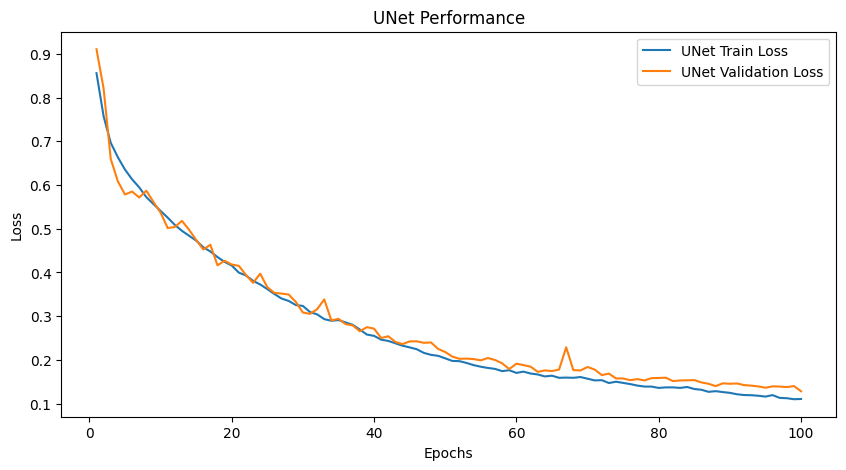

In [33]:
epochs = range(1, len(unet_train_loss) + 1)

plt.figure(figsize=(10, 5))

plt.plot(epochs, unet_train_loss, label='UNet Train Loss')
plt.plot(epochs, unet_val_loss, label='UNet Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('UNet Performance')
plt.legend()

plt.show()

**FCN8s Performance**

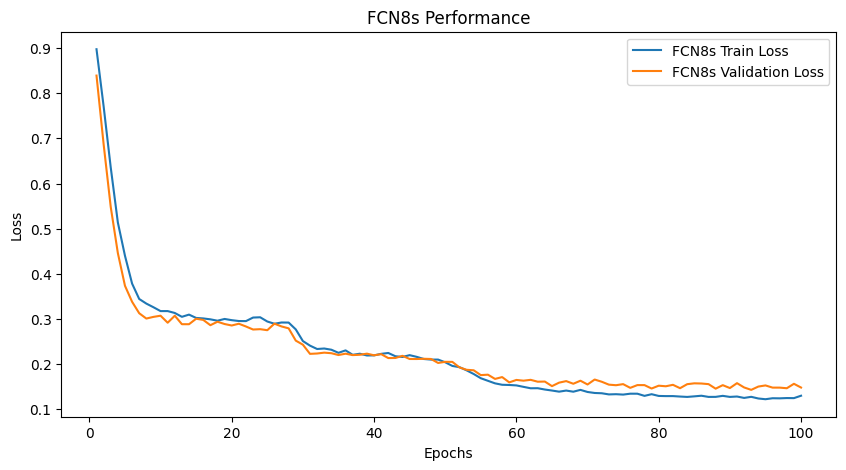

In [34]:
epochs = range(1, len(fcn_train_loss) + 1)

plt.figure(figsize=(10, 5))

plt.plot(epochs, fcn_train_loss, label='FCN8s Train Loss')
plt.plot(epochs, fcn_val_loss, label='FCN8s Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('FCN8s Performance')
plt.legend()

plt.show()

**Comparison of Loss**

In [35]:
def test_engine(dataloader, model, loss_fn):
    model.eval()
    loss_one_step = 0
    loop = tqdm(dataloader)

    for data, targets in loop:
        data = data.to('cuda')
        targets = targets.float().to(device="cuda")
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                predictions = model(data)
                loss = loss_fn(targets, predictions)
        loss_one_step += loss.item()

        loop.set_postfix(loss=loss.item())

    return loss_one_step / len(dataloader)

unet_test_loss = test_engine(test_dataloader, unet, dice_loss)
fcn_test_loss = test_engine(test_dataloader, fcn, dice_loss)

100%|██████████| 4/4 [00:01<00:00,  2.15it/s, loss=0.122]


In [36]:
loss_df = pd.DataFrame({'Model':['UNet', 'FCN8s'],
                        'Train Loss':[unet_train_loss[-1], fcn_train_loss[-1]],
                        'Validation Loss':[unet_val_loss[-1], fcn_val_loss[-1]],
                        'Test Loss':[unet_test_loss, fcn_test_loss]})

loss_df

,Model,Train Loss,Validation Loss,Test Loss
0,UNet,0.110611,0.128240,0.155021
1,FCN8s,0.130191,0.148296,0.145706


**Comparison of Dice Coefficient**

In [37]:
def calculate_dice_coefficient_per_class(ground_truth, predicted, num_classes):
    dice_scores = []
    for c in range(num_classes):
        # Extract the class mask for ground truth and predictions
        gt_class = (ground_truth == c).float()
        pred_class = (predicted == c).float()

        # Calculate intersection and union
        intersection = (gt_class * pred_class).sum()
        dice_score = (2.0 * intersection) / (gt_class.sum() + pred_class.sum() + 1e-5)
        dice_scores.append(dice_score.item())
    return dice_scores

def calculate_average_dice_coefficient(ground_truths, predictions, num_classes):
    num_samples = len(ground_truths)
    dice_coefficients = np.zeros((num_samples, num_classes))
    for i in range(num_samples):
        dice_coefficients[i] = calculate_dice_coefficient_per_class(ground_truths[i], predictions[i], num_classes)
    return dice_coefficients.mean(axis=0)  # Per-class average

def dice_coeff_engine(dataloader, model, num_classes):
    model.eval()
    scores = []
    loop = tqdm(dataloader)

    for data, targets in loop:
        data = data.to('cuda')
        targets = targets.long().to('cuda')
        with torch.no_grad():
            with torch.amp.autocast('cuda'):
                predictions = model(data)
                # Get the predicted class for each pixel
                predicted_classes = predictions.argmax(dim=1)
                score = calculate_average_dice_coefficient(targets, predicted_classes, num_classes)
        scores.append(score)
        loop.set_postfix(mean_dice=np.mean(score))

    # Average across all batches and return per-class dice scores
    mean_dice_per_class = np.mean(scores, axis=0)
    return mean_dice_per_class, mean_dice_per_class.mean()

num_classes = 12
unet_train_score, unet_train_mean_dice = dice_coeff_engine(train_dataloader, unet, num_classes)
unet_val_score, unet_val_mean_dice = dice_coeff_engine(val_dataloader, unet, num_classes)
unet_test_score, unet_test_mean_dice = dice_coeff_engine(test_dataloader, unet, num_classes)

fcn_train_score, fcn_train_mean_dice = dice_coeff_engine(train_dataloader, fcn, num_classes)
fcn_val_score, fcn_val_mean_dice = dice_coeff_engine(val_dataloader, fcn, num_classes)
fcn_test_score, fcn_test_mean_dice = dice_coeff_engine(test_dataloader, fcn, num_classes)

100%|██████████| 4/4 [00:02<00:00,  1.61it/s, mean_dice=0.0547]


In [38]:
print('------ Dice Coeeficient of UNet in Train Dataset ------')
for i in range(12):
  print(f'Class {i}: {unet_train_score[i]}')

print('------ Dice Coeeficient of UNet in Validation Dataset ------')
for i in range(12):
  print(f'Class {i}: {unet_val_score[i]}')

print('------ Dice Coeeficient of UNet in Test Dataset ------')
for i in range(12):
  print(f'Class {i}: {unet_test_score[i]}')

print('------ Dice Coeeficient of FCN in Train Dataset ------')
for i in range(12):
  print(f'Class {i}: {fcn_train_score[i]}')

print('------ Dice Coeeficient of FCN in Validation Dataset ------')
for i in range(12):
  print(f'Class {i}: {fcn_val_score[i]}')

print('------ Dice Coeeficient of FCN in Test Dataset ------')
for i in range(12):
  print(f'Class {i}: {fcn_test_score[i]}')

------ Dice Coeeficient of UNet in Train Dataset ------
Class 0: 0.3476642785346485
Class 1: 0.36849714969779596
Class 2: 0.0
Class 3: 0.0
Class 4: 0.0
Class 5: 0.0
Class 6: 0.0
Class 7: 0.0
Class 8: 0.0
Class 9: 0.0
Class 10: 0.0
Class 11: 0.0
------ Dice Coeeficient of UNet in Validation Dataset ------
Class 0: 0.32610721061355435
Class 1: 0.39541884596304344
Class 2: 0.0
Class 3: 0.0
Class 4: 0.0
Class 5: 0.0
Class 6: 0.0
Class 7: 0.0
Class 8: 0.0
Class 9: 0.0
Class 10: 0.0
Class 11: 0.0
------ Dice Coeeficient of UNet in Test Dataset ------
Class 0: 0.18811621163040398
Class 1: 0.42707641762681303
Class 2: 0.0
Class 3: 0.0
Class 4: 0.0
Class 5: 0.0
Class 6: 0.0
Class 7: 0.0
Class 8: 0.0
Class 9: 0.0
Class 10: 0.0
Class 11: 0.0
------ Dice Coeeficient of FCN in Train Dataset ------
Class 0: 0.35505628422484736
Class 1: 0.39993924845342915
Class 2: 0.0
Class 3: 0.0
Class 4: 0.0
Class 5: 0.0
Class 6: 0.0
Class 7: 0.0
Class 8: 0.0
Class 9: 0.0
Class 10: 0.0
Class 11: 0.0
------ Dice Co

In [39]:
score_df = pd.DataFrame({'Model':['UNet', 'FCN8s'],
                        'Train Score':[unet_train_mean_dice, fcn_train_mean_dice],
                        'Validation Score':[unet_val_mean_dice, fcn_val_mean_dice],
                        'Test Score':[unet_test_mean_dice, fcn_test_mean_dice]})

score_df

,Model,Train Score,Validation Score,Test Score
0,UNet,0.059680,0.060127,0.051266
1,FCN8s,0.062916,0.063093,0.054208


# Model Visualization

In [40]:
def inference(tensor, model):
    with torch.no_grad():
        tensor = torch.unsqueeze(tensor, dim=0).to('cuda')
        result = model(tensor)
        result = torch.softmax(result, dim=1)
    return result

def imshow_from_tensor(tensor):
    # Get the class with the highest probability for each pixel
    tensor = torch.argmax(tensor, dim=0).cpu().detach().numpy()
    return tensor

**UNet**

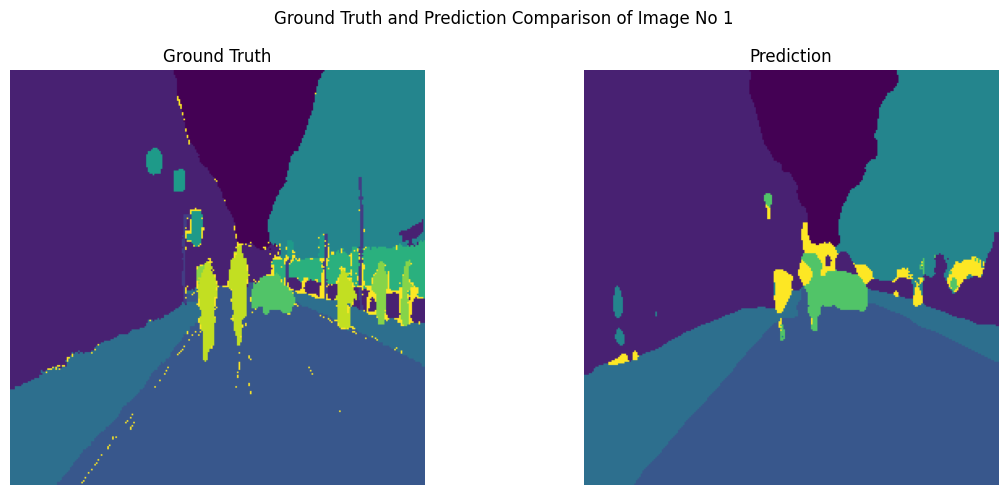

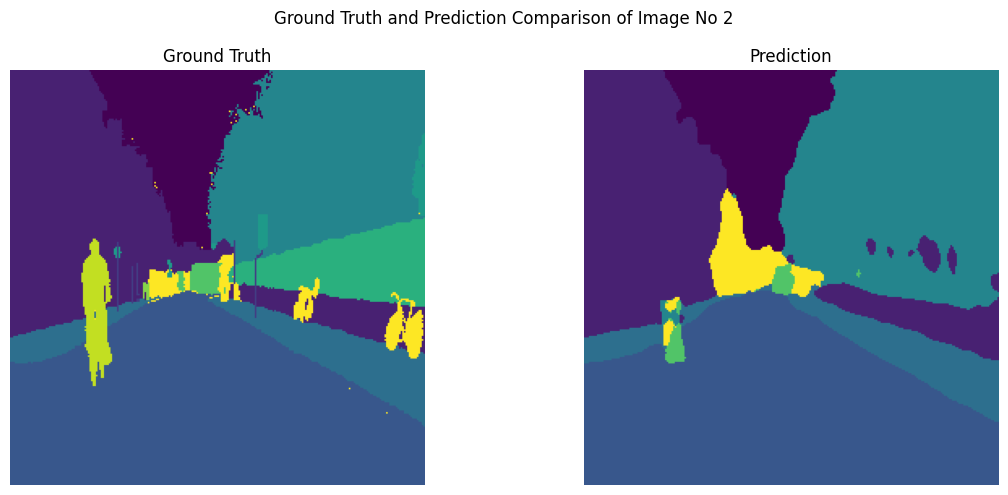

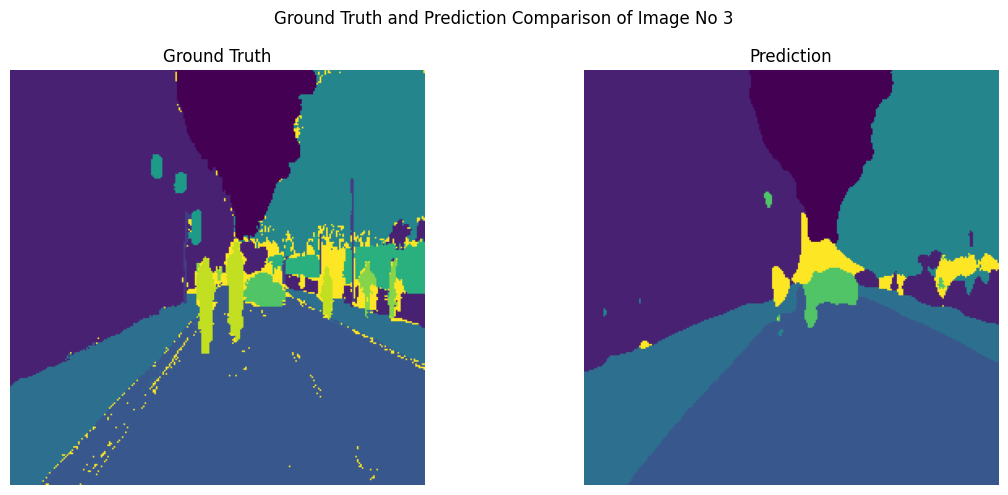

In [41]:
get = 3

for i in range(get):
    data, targets = test_datasets[i]
    result = inference(data, unet)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    image_ori = imshow_from_tensor(targets)
    plt.imshow(image_ori)
    plt.axis('off')
    plt.title('Ground Truth')

    plt.subplot(1, 2, 2)
    image = imshow_from_tensor(result[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('Prediction')

    plt.suptitle(f'Ground Truth and Prediction Comparison of Image No {i+1}')
    plt.tight_layout()
    plt.show()

**FCN**

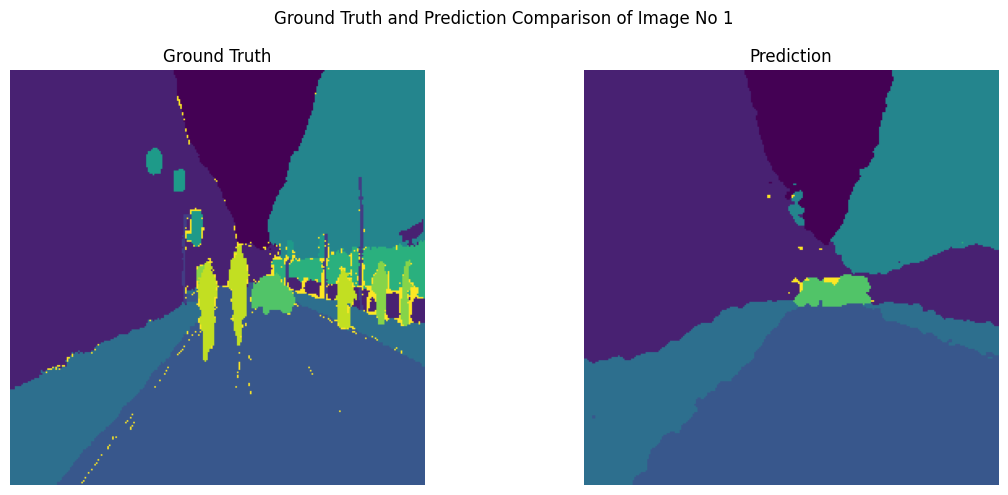

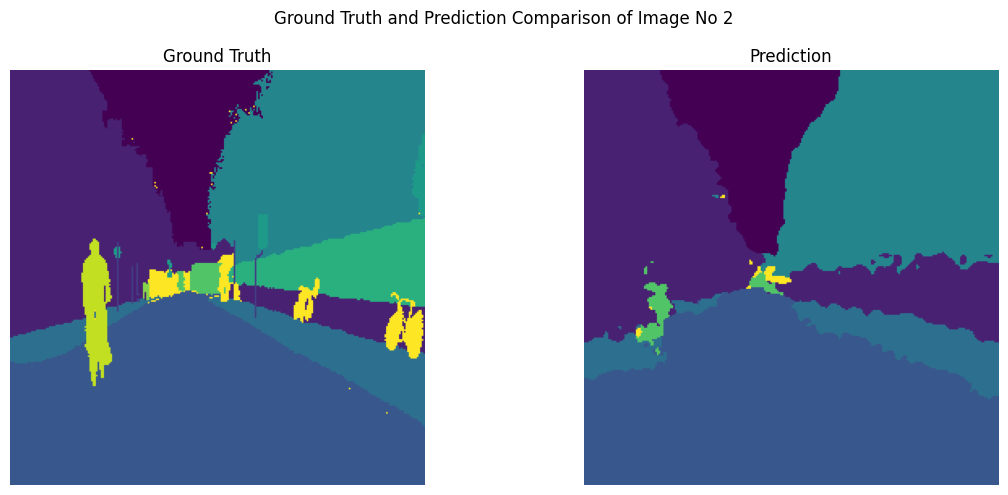

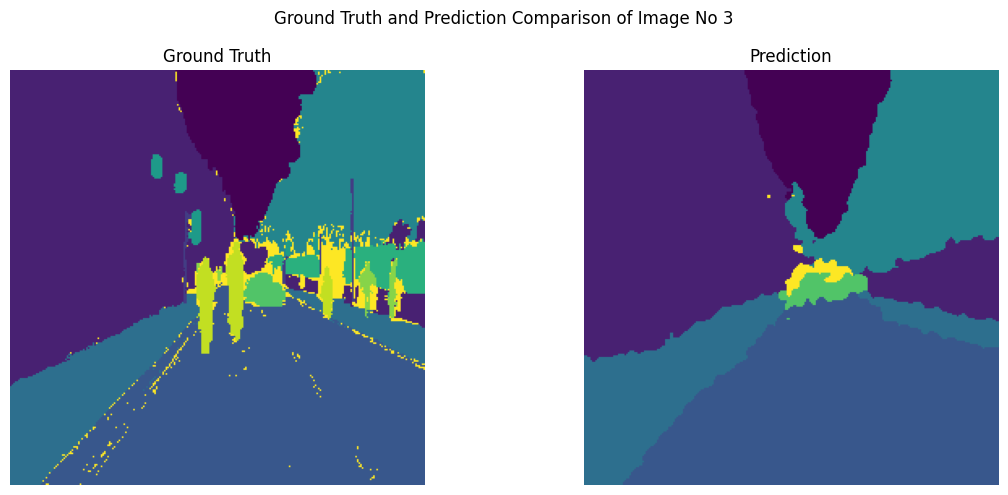

In [42]:
get = 3

for i in range(get):
    data, targets = test_datasets[i]
    result = inference(data, fcn)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    image_ori = imshow_from_tensor(targets)
    plt.imshow(image_ori)
    plt.axis('off')
    plt.title('Ground Truth')

    plt.subplot(1, 2, 2)
    image = imshow_from_tensor(result[0])
    plt.imshow(image)
    plt.axis('off')
    plt.title('Prediction')

    plt.suptitle(f'Ground Truth and Prediction Comparison of Image No {i+1}')
    plt.tight_layout()
    plt.show()